## Machine Learning: Building a regression model using Lasso Regression

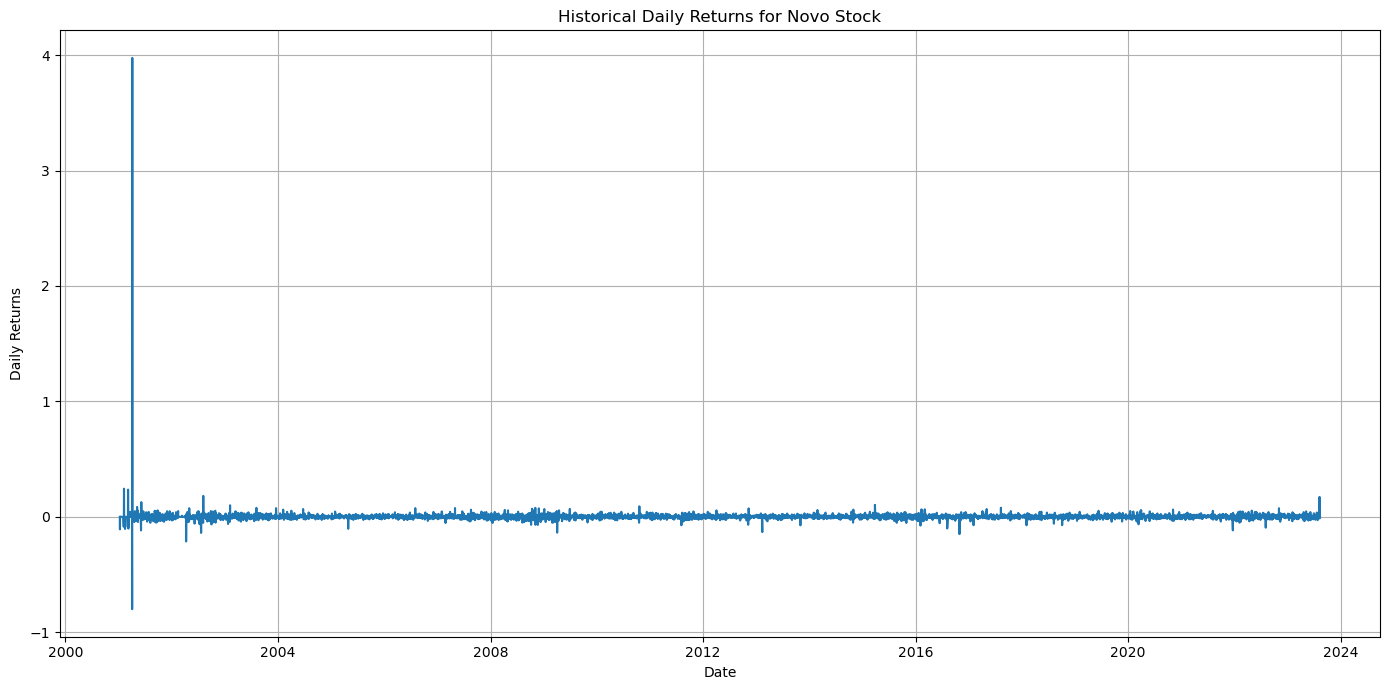

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score

## IMPORTING THE CLEANED DATAFRAME
df = pd.read_csv('cleaned_data.csv')

### Lasso Regression

In [12]:
# Splitting the data into features and target variable
X = df_merged_clean[['mean', 'std', 'volume']]  # Features
y = df_merged_clean['daily_return']  # Target variable

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Transforming the data set and creating interaction terms
poly_trans = PolynomialFeatures(degree=3, include_bias=False)
X_train_p = poly_trans.fit_transform(X_train)
X_test_p = poly_trans.transform(X_test)  # Use transform, not fit_transform for the test set

# Rescaling our data
rescaler = StandardScaler().fit(X_train_p)
X_train2 = rescaler.transform(X_train_p)
X_test2 = rescaler.transform(X_test_p)

ValueError: Input X contains NaN.
PolynomialFeatures does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Creating a function that calculates the mean squared error
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

output = []
lambdas = np.logspace(-4, 4, 20)

for lambda_ in lambdas:
    reg = Lasso(alpha=lambda_, random_state=1)
    reg.fit(X_train2, y_train)
    output.append(
        [
            lambda_,
            rmse(reg.predict(X_train2), y_train),
            rmse(reg.predict(X_test2), y_test),
        ]
    )

In [ ]:
# Visualization and selection of the optimal lambda cvalue
MSE_df = pd.DataFrame(
    data=output, columns=["lambda", "MSE train", "MSE test"]
).set_index("lambda")

MSE_df.plot(logx=True, logy=True)
plt.ylabel('RMSE')
plt.title('RMSE for different lambda values')
plt.show()

best_fit = MSE_df["MSE test"].nsmallest(1)
lambda_opt, RMSE_min = next(best_fit.items())
print(f"Minimum RMSE = {RMSE_min:.3f} found for lambda = {lambda_opt:.4f}.")

In [ ]:
# After fitting the Lasso model
reg = Lasso(alpha=lambda_opt)
reg.fit(X_train2, y_train)

# Creating predicted values
y_pred = reg.predict(X_test2)

# Extracting coefficients and intercept
coefficients = reg.coef_
intercept = reg.intercept_

# Displaying the results
print("Intercept:", intercept)
print("\nCoefficients:")
for feature, coef in zip(poly_trans.get_feature_names_out(X.columns), coefficients):
    print(f"{feature}: {coef}")

### Residuals Analysis

In [ ]:
residuals = y_test - y_pred

# Plotting residuals
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')  # Adding a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Cross-Validation

In [ ]:
# Using the optimal lambda value
reg = Lasso(alpha=lambda_opt)

# Computing cross-validated RMSE scores
scores = cross_val_score(reg, X_train2, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-scores)

print("Cross-validated RMSE scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard Deviation of RMSE:", rmse_scores.std())

#### Interpretation:

Our model, on average, has an error of about 0.0234 (23,4%). This is the typical difference between the observed values and the model's predictions.

The range of RMSE values across the 5 folds goes from around 0.017 to 0.036. This range gives you an idea of the best and worst-case scenarios for your model's performance on unseen data.

The standard deviation of the RMSE values across the folds is 0.00675. This indicates that there's some variability in how well the model performs on different subsets of the data. If this value were very high, it might be a cause for concern, as it would indicate that the model's performance is very inconsistent. In your case, while there's some variability, it's not excessively high.

In conclusion, cross-validation provides a more robust estimate of a model's performance than a single train-test split. By looking at the range and standard deviation of the RMSE values, you can get a sense of the model's consistency and reliability. If you're comparing multiple models, you'd typically choose the one with the lowest mean RMSE, provided its performance is consistent across folds (i.e., a low standard deviation of RMSE).